In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

### Crappified data

Prepare the input data by crappifying images.

In [5]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [8]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

### Pre-train generator

Now let's pretrain the generator.

In [13]:
bs,size=32,128
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [11]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [14]:
data_gen = get_data(bs,size)

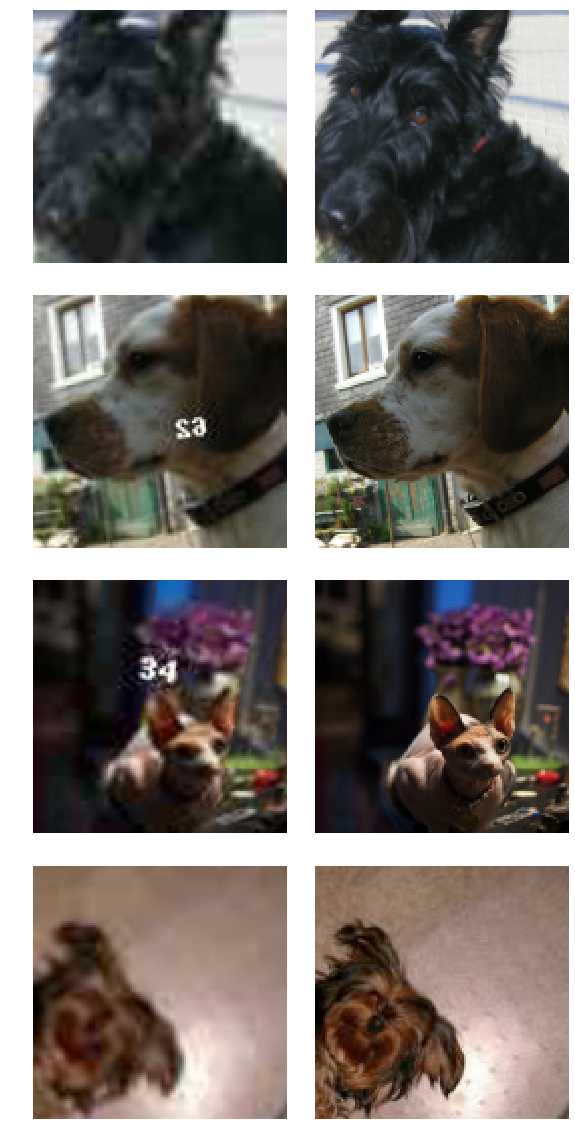

In [16]:
data_gen.show_batch(4)

In [19]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [20]:
learn_gen = create_gen_learner()

In [21]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
1,0.062675,0.052185,00:36
2,0.053021,0.046450,00:32


In [23]:
learn_gen.unfreeze()

In [24]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
1,0.051279,0.044694,00:34
2,0.047945,0.042732,00:34
3,0.046162,0.041874,00:34


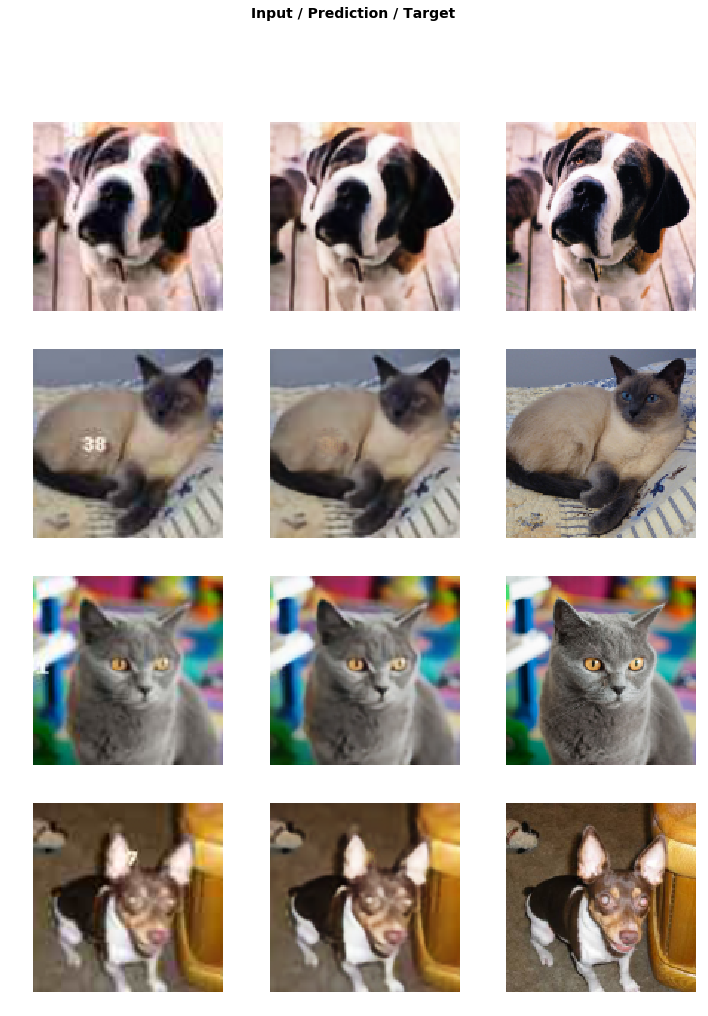

In [25]:
learn_gen.show_results(rows=4)

In [26]:
learn_gen.save('gen-pre2')

### Save Generated Images

In [70]:
learn_gen.load('gen-pre2');

In [71]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [72]:
path_gen.mkdir(exist_ok=True)

In [74]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [75]:
save_preds(data_gen.fix_dl)

In [76]:
learn_gen.purge();

Pretrain the critic on crappy vs not crappy.

In [77]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data


In [78]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

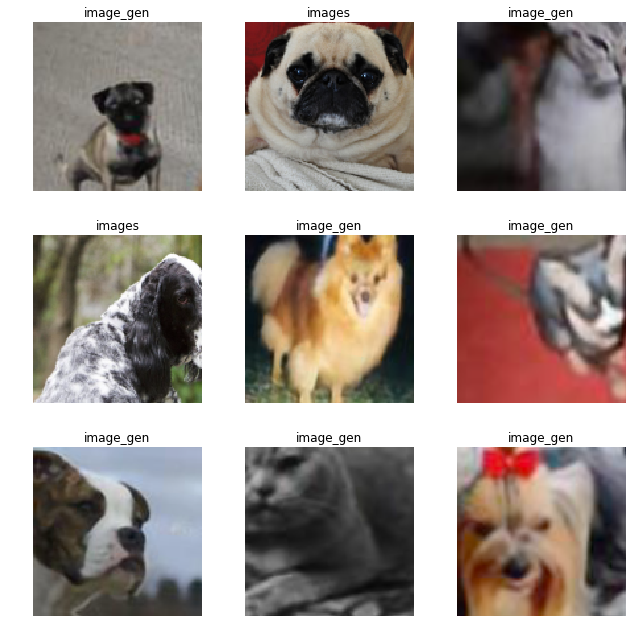

In [79]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [81]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())